In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

ticker = 'AES'
stock_news = requests.get(f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}&limit=100&apikey={fm_key}').json()
stock_news = pd.DataFrame(stock_news)
stock_news = stock_news[stock_news['site'].isin(['24/7 Wall Street', 'CNBC', 'Forbes', 'Barrons', 'Market Watch'])]

if len(stock_news) == 0:
    print('empty')

text_str = ' '.join(str(x) for x in stock_news['text'])

print(text_str)

Stocks are higher across the board at the midpoint of trading on Monday as investors are buying the massive Friday dip despite some hawkish commentary from St. UPS saw its shares surge over 9% after reporting a blowout quarter with revenue growth of 27%. As investors anticipate earnings from other tech giants like Alphabet and Microsoft, Q.ai's deep learning algorithms have found today's top buys. Investors have been pouring money into environmental, social and governance (ESG) stocks and exchange-traded funds at a record pace this year.


### 1. Summerization

In [3]:
# import gensim
# from gensim.summarization import summarize

# text_summ = summarize(text_str)
# print(text_summ)

In [4]:
# plt.figure(figsize = (10, 10))
# sum_plot = text_summ.split(' .\n')
# for i in range(len(sum_plot)):
#     plt.text(0.1, 1 - (i+1)*0.5, sum_plot[len(sum_plot)-1-i], size = 30,\
#              horizontalalignment='center', verticalalignment='center')
    
# plt.axis('off')
# plt.show()

### 2. Extraction with importance:   
- Refer to: https://medium.com/analytics-vidhya/sentence-extraction-using-textrank-algorithm-7f5c8fd568cd

In [7]:
import re
from pprint import pprint

import numpy as np
from nltk import sent_tokenize, word_tokenize

from nltk.cluster.util import cosine_distance

MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)

def normalize_whitespace(text):
    """
    Translates multiple whitespace into single space character.
    If there is at least one new line character chunk is replaced
    by single LF (Unix new line) character.
    """
    return MULTIPLE_WHITESPACE_PATTERN.sub(_replace_whitespace, text)


def _replace_whitespace(match):
    text = match.group()

    if "\n" in text or "\r" in text:
        return "\n"
    else:
        return " "
    

def is_blank(string):
    """
    Returns `True` if string contains only white-space characters
    or is empty. Otherwise `False` is returned.
    """
    return not string or string.isspace()


def get_symmetric_matrix(matrix):
    """
    Get Symmetric matrix
    :param matrix:
    :return: matrix
    """
    return matrix + matrix.T - np.diag(matrix.diagonal())


def core_cosine_similarity(vector1, vector2):
    """
    measure cosine similarity between two vectors
    :param vector1:
    :param vector2:
    :return: 0 < cosine similarity value < 1
    """
    return 1 - cosine_distance(vector1, vector2)

class TextRank4Sentences():
    
    def __init__(self):
        self.damping = 0.85  # damping coefficient, usually is .85
        self.min_diff = 1e-5  # convergence threshold
        self.steps = 100  # iteration steps
        self.text_str = None
        self.sentences = None
        self.pr_vector = None

    def _sentence_similarity(self, sent1, sent2, stopwords=None):
        if stopwords is None:
            stopwords = []

        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        # build the vector for the first sentence
        for w in sent1:
            if w in stopwords:
                continue
            vector1[all_words.index(w)] += 1

        # build the vector for the second sentence
        for w in sent2:
            if w in stopwords:
                continue
            vector2[all_words.index(w)] += 1

        return core_cosine_similarity(vector1, vector2)
    
    def _build_similarity_matrix(self, sentences, stopwords=None):
        # create an empty similarity matrix
        sm = np.zeros([len(sentences), len(sentences)])

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2:
                    continue

                sm[idx1][idx2] = self._sentence_similarity(sentences[idx1], sentences[idx2], stopwords=stopwords)

        # Get Symmeric matrix
        sm = get_symmetric_matrix(sm)

        # Normalize matrix by column
        norm = np.sum(sm, axis=0)
        sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

        return sm_norm

    def _run_page_rank(self, similarity_matrix):

        pr_vector = np.array([1] * len(similarity_matrix))

        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr_vector = (1 - self.damping) + self.damping * np.matmul(similarity_matrix, pr_vector)
            if abs(previous_pr - sum(pr_vector)) < self.min_diff:
                break
            else:
                previous_pr = sum(pr_vector)

        return pr_vector
    
    def _get_sentence(self, index):

        try:
            return self.sentences[index]
        except IndexError:
            return ""

    def get_top_sentences(self, number=5):

        top_sentences = {}

        if self.pr_vector is not None:

            sorted_pr = np.argsort(self.pr_vector)
            sorted_pr = list(sorted_pr)
            sorted_pr.reverse()

            index = 0
            for epoch in range(number):
                #print (str(sorted_pr[index]) + " : " + str(self.pr_vector[sorted_pr[index]]))
                sent = self.sentences[sorted_pr[index]]
                sent = normalize_whitespace(sent)
                top_sentences[sent] = self.pr_vector[sorted_pr[index]]
                index += 1

        return top_sentences
    
    def analyze(self, text, stop_words=None):
        self.text_str = text
        self.sentences = sent_tokenize(self.text_str)

        tokenized_sentences = [word_tokenize(sent) for sent in self.sentences]

        similarity_matrix = self._build_similarity_matrix(tokenized_sentences, stop_words)

        self.pr_vector = self._run_page_rank(similarity_matrix)
        
        #print(self.pr_vector)

tr4sh = TextRank4Sentences()
tr4sh.analyze(text_str)

# len(tr4sh.sentences)
try:
     top_sents = tr4sh.get_top_sentences(5)
except: 
     top_sents = tr4sh.get_top_sentences(3)

top_sents

{'Investors have been pouring money into environmental, social and governance (ESG) stocks and exchange-traded funds at a record pace this year.': 1.1178978177405954,
 "As investors anticipate earnings from other tech giants like Alphabet and Microsoft, Q.ai's deep learning algorithms have found today's top buys.": 1.0788843868754947,
 'Stocks are higher across the board at the midpoint of trading on Monday as investors are buying the massive Friday dip despite some hawkish commentary from St. UPS saw its shares surge over 9% after reporting a blowout quarter with revenue growth of 27%.': 0.80321779538391}

### Plot:

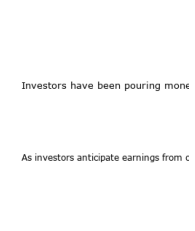

In [11]:
from matplotlib.pyplot import imshow
import numpy as np
from IPython.display import display

from PIL import Image, ImageDraw, ImageFont

# create an image
out = Image.new("RGB", (250, 300), (255, 255, 255))

# get a font
# fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
# get a drawing context
d = ImageDraw.Draw(out)

# draw multiline text
# d.multiline_text((10,10), "Hello\nWorld", fill=(0, 0, 0))

# fnt = ImageFont.truetype("Verdana.ttf", 10)
i = 1
for key in top_sents:
    fnt = ImageFont.truetype("Verdana.ttf", int(12*float(top_sents[key])))
    d.text((20, 50*2*i), str(key), fill = "#000", font = fnt)
    i += 1

# fnt = ImageFont.truetype("Verdana.ttf", 16)
# for i in range(len(test)):
#     d.text((10, (i+1)*50), test[len(test)-1-i], fill = (0, 0, 0), font = fnt)

plt.axis('off')
_ = imshow(out)
out.save(f"{ticker}.jpeg", dpi=(22000, 22000))

In [47]:
def top_news(ticker, n = 5):
    
    import requests
    import pandas as pd
    import matplotlib.pyplot as plt

    fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

    stock_news = requests.get(f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}\
    &limit=100&apikey={fm_key}').json()
    stock_news = pd.DataFrame(stock_news)
    stock_news = stock_news[stock_news['site'].isin(['24/7 Wall Street', 'CNBC', 'Forbes', 'Barrons',\
                                                     'Market Watch'])]
    
    if len(stock_news) == 0:
        return None

    text_str = ' '.join(str(x) for x in stock_news['text'])
    
    import re
    from pprint import pprint

    import numpy as np
    from nltk import sent_tokenize, word_tokenize

    from nltk.cluster.util import cosine_distance

    MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)

    def normalize_whitespace(text):
        """
        Translates multiple whitespace into single space character.
        If there is at least one new line character chunk is replaced
        by single LF (Unix new line) character.
        """
        return MULTIPLE_WHITESPACE_PATTERN.sub(_replace_whitespace, text)


    def _replace_whitespace(match):
        text = match.group()

        if "\n" in text or "\r" in text:
            return "\n"
        else:
            return " "


    def is_blank(string):
        """
        Returns `True` if string contains only white-space characters
        or is empty. Otherwise `False` is returned.
        """
        return not string or string.isspace()


    def get_symmetric_matrix(matrix):
        """
        Get Symmetric matrix
        :param matrix:
        :return: matrix
        """
        return matrix + matrix.T - np.diag(matrix.diagonal())


    def core_cosine_similarity(vector1, vector2):
        """
        measure cosine similarity between two vectors
        :param vector1:
        :param vector2:
        :return: 0 < cosine similarity value < 1
        """
        return 1 - cosine_distance(vector1, vector2)

    class TextRank4Sentences():

        def __init__(self):
            self.damping = 0.85  # damping coefficient, usually is .85
            self.min_diff = 1e-5  # convergence threshold
            self.steps = 100  # iteration steps
            self.text_str = None
            self.sentences = None
            self.pr_vector = None

        def _sentence_similarity(self, sent1, sent2, stopwords=None):
            if stopwords is None:
                stopwords = []

            sent1 = [w.lower() for w in sent1]
            sent2 = [w.lower() for w in sent2]

            all_words = list(set(sent1 + sent2))

            vector1 = [0] * len(all_words)
            vector2 = [0] * len(all_words)

            # build the vector for the first sentence
            for w in sent1:
                if w in stopwords:
                    continue
                vector1[all_words.index(w)] += 1

            # build the vector for the second sentence
            for w in sent2:
                if w in stopwords:
                    continue
                vector2[all_words.index(w)] += 1

            return core_cosine_similarity(vector1, vector2)

        def _build_similarity_matrix(self, sentences, stopwords=None):
            # create an empty similarity matrix
            sm = np.zeros([len(sentences), len(sentences)])

            for idx1 in range(len(sentences)):
                for idx2 in range(len(sentences)):
                    if idx1 == idx2:
                        continue

                    sm[idx1][idx2] = self._sentence_similarity(sentences[idx1], sentences[idx2], stopwords=stopwords)

            # Get Symmeric matrix
            sm = get_symmetric_matrix(sm)

            # Normalize matrix by column
            norm = np.sum(sm, axis=0)
            sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

            return sm_norm

        def _run_page_rank(self, similarity_matrix):

            pr_vector = np.array([1] * len(similarity_matrix))

            # Iteration
            previous_pr = 0
            for epoch in range(self.steps):
                pr_vector = (1 - self.damping) + self.damping * np.matmul(similarity_matrix, pr_vector)
                if abs(previous_pr - sum(pr_vector)) < self.min_diff:
                    break
                else:
                    previous_pr = sum(pr_vector)

            return pr_vector

        def _get_sentence(self, index):

            try:
                return self.sentences[index]
            except IndexError:
                return ""

        def get_top_sentences(self, number=5):

            top_sentences = {}

            if self.pr_vector is not None:

                sorted_pr = np.argsort(self.pr_vector)
                sorted_pr = list(sorted_pr)
                sorted_pr.reverse()

                index = 0
                for epoch in range(number):
                    #print (str(sorted_pr[index]) + " : " + str(self.pr_vector[sorted_pr[index]]))
                    sent = self.sentences[sorted_pr[index]]
                    sent = normalize_whitespace(sent)
                    top_sentences[sent] = self.pr_vector[sorted_pr[index]]
                    index += 1

            return top_sentences

        def analyze(self, text, stop_words=None):
            self.text_str = text
            self.sentences = sent_tokenize(self.text_str)

            tokenized_sentences = [word_tokenize(sent) for sent in self.sentences]

            similarity_matrix = self._build_similarity_matrix(tokenized_sentences, stop_words)

            self.pr_vector = self._run_page_rank(similarity_matrix)

            #print(self.pr_vector)

    tr4sh = TextRank4Sentences()
    tr4sh.analyze(text_str)
    top_sents = tr4sh.get_top_sentences(min(n, len(tr4sh.sentences)))
    
    from matplotlib.pyplot import imshow
    import numpy as np
    from IPython.display import display

    from PIL import Image, ImageDraw, ImageFont

    # create an image
    out = Image.new("RGB", (2500, 400), (255, 255, 255))

    # get a font
    # fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
    # get a drawing context
    d = ImageDraw.Draw(out)

    # draw multiline text
    # d.multiline_text((10,10), "Hello\nWorld", fill=(0, 0, 0))

    # fnt = ImageFont.truetype("Verdana.ttf", 10)
    i = 1
    for key in top_sents:
        fnt = ImageFont.truetype("Verdana.ttf", int(13*float(top_sents[key])))
        d.text((20, 50*i), str(key), fill = "#000", font = fnt)
        i += 1

    # fnt = ImageFont.truetype("Verdana.ttf", 16)
    # for i in range(len(test)):
    #     d.text((10, (i+1)*50), test[len(test)-1-i], fill = (0, 0, 0), font = fnt)

    plt.axis('off')
    #_ = imshow(out)
    out.save(f"{ticker}.jpg", dpi=(12000, 12000))

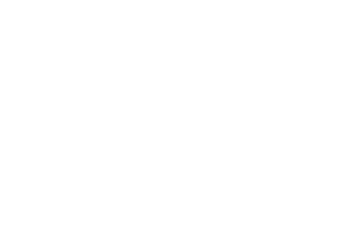

In [49]:
tickers = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={fm_key}').json()
tickers = pd.DataFrame(tickers)
tickers = tickers.loc[:,'symbol'].to_list()

for ticker in tickers[0:20]:
    top_news(ticker)